## Pipeline for generating and comparing templates

# Imports and helpers

In [1]:
#Imports
import numpy as np
# from midiutil import MIDIFile
import matplotlib.pyplot as plt
import ternary
from ternary.helpers import simplex_iterator

import theano.tensor as T
from theano import function
import theano

# helpers from my files
import sys
sys.path.insert(0, 'helpers/')
from tree_parser import TreeParser
# from midi import *
from bidict import bidict

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

The constants for the rhythm. L is the length [in beats] of a rhythm, N is the number of levels in the tree, including level 0.

In [2]:
# CONSTANTS
L = 8 # length of measure
N = int(np.log2(L)+1) # Number of levels (including 0)
TN = 2 # number of levels for templates
N

4

In [3]:
# Initial THEANO symbolic variables

p_split = T.dscalar('p_split')
p_beat = T.dscalar('p_beat')
p_rest = T.dscalar('p_rest')

In [4]:
#Graph for visualizing the loss function
import ternary
from ternary.helpers import simplex_iterator

def plot_templates_similarity(template1, template2, template_pairs, scale=40):
    '''
    Function plotting the loss function for any 2 templates to compare
    '''
    def generate_heatmap_data(scale=scale):
        d = dict()
        for (i, j, k) in simplex_iterator(scale):
            d[(i, j, k)] =  cost_f([i/scale,j/scale,k/scale])
        return d  
    
    fontsize = 10
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
    ax1.axis('off')
    ax2.axis('off')
    plt.title(f"Loss function between {template1} and {template2}", pad=40, fontsize=20)   
    
    # LEFT PLOT (HEATMAP)
    figure1, tax1 = ternary.figure(scale=scale, ax=ax1)  
    data = generate_heatmap_data(scale)
    tax1.heatmap(data, style="triangular", cmap=plt.cm.YlGnBu)
  
    tax1.left_corner_label("p_rest", fontsize=fontsize)
    tax1.right_corner_label("p_split", fontsize=fontsize)
    tax1.top_corner_label("p_beat", fontsize=fontsize)

    # RIGHT PLOT (GRADIENT DESCENT)
    figure2, tax2 = ternary.figure(scale=scale, ax=ax2)  
    tax2.scatter([tuple(scale* y for y in template_pairs[(template1, template2)].get('x'))], color='red', marker="D", label='start points') # plot start points
    
    tax2.boundary() 
    tax2.left_corner_label("p_rest", fontsize=fontsize)
    tax2.right_corner_label("p_split", fontsize=fontsize)
    tax2.top_corner_label("p_beat", fontsize=fontsize)

    # plotting
    
    plt.savefig(f"graphs/loss/loss_{template1}_{template2}", dpi=400, bbox_inches='tight')
    plt.show()

# Set of all trees, and probability of all trees

To generate the trees, we use a bottom-up dynamic programming paradigm, by first generating 1-level trees, then using them as building blocks for 2-levels trees, and so on, up to N. All the trees are of the form of recursive tuples, where the presence of a tuple means a p_split node, and the presence of p_beat and p_rest mean p_beat or p_rest terminals. All the trees are then stored inside a set of all trees called **all_trees**. Note that at the first level, trees can only have p_beat or p_rest leaves, since otherwise the tree would never stop.

In parallel, we do compute the probability of each tree by simply mutilplying the value of each root and node of the tree, and storing them as a Theano product symbolic carible. The product of the probabilities is as well done with the bottom-up fasion. Then we create a dictionary **tree2prob[tree]** where the key is a tree, and the value is a Theano symbolic probability.

In [5]:
# Initiation base case
trees_old = set()

for i in range(N):
    # Trivial trees for this level
    trees_new = set()
    trees_new.add(p_beat)
    trees_new.add(p_rest)

    # Trivial probs for this level
    trees_prob_new = dict()
    trees_prob_new[p_beat] = p_beat
    trees_prob_new[p_rest] = p_rest

    # Recursion to pick all smaller trees to build large tree
    for elem1 in trees_old:
        for elem2 in trees_old:
            trees_new.add((elem1, elem2))      
            trees_prob_new[(elem1, elem2)] = p_split*trees_prob_old[elem1]*trees_prob_old[elem2]
        
    # Parameters update
    trees_old = trees_new
    trees_prob_old = trees_prob_new
    

all_trees = trees_new
tree2prob = trees_prob_new
        
len(all_trees)

1446

# Set of all rhythms

We generate all rhythms by simply converting all integers from 0 to 2^L into binary, and then store them as tuples of characters for each 0 and 1. All the rhythms of type tuple are then stored into a set called **all_rhythms**.

In [6]:
all_rhythms = set()

for i in range(2**L): # populating
    all_rhythms.add( tuple(("{0:0%sb}" %L).format(i)) ) # convert from binary int format to tuple of char format
    
len(all_rhythms)

256

# 2-way dictionnary between trees and rhythms

Each tree leads to 1 rhythm, but many trees can lead to the same rhythm. We use a data structure call bidict which, from a one way dictionary, generate the inverse dictionary automatically. 

We first generate a dictionary from tree to its one **rhythm tree2rhythm[tree]**, since its a one to one relation and easier to implement, and then after we'll let the bidict sutructure automatically generate the inverse dictionary from rhythm to tree **rhythm2trees[rhythm]**.

The **rhythm tree2rhythm[tree]** dictionary is created by generating the rhythm recursively by looking at the tree from the root and recursing over the 2 halves of the trees and so forth. Then the **rhythm2trees[rhythm]** is computed automatically by bidict, and is a dictionary from a rhythm to a list of trees.

In [7]:
# Helper function to find the rhythm generated by a tree
def tree_to_rhythm(tree, size=L):    
    if(p_beat == tree):
        tup = ('1',) + ('0',) * int(size-1)
        return tup    
    elif(p_rest == tree):
        tup = ('0',) * int(size)
        return tup    
    else:
        return tree_to_rhythm(tree[0], size/2) + tree_to_rhythm(tree[1], size/2)
    
trees2rhythms = bidict() # initial bidirection dictionary (can't be stored with pickle.....)

for tree in all_trees:
    trees2rhythms[tree] = tree_to_rhythm(tree)
    
# 2 dict for the 2 directions 
rhythm2trees = trees2rhythms.inverse
tree2rhythm  = dict(trees2rhythms)

len(rhythm2trees)

256

# Probability of each rhythm (set)

To compute the probability of erach rhythm, we simply sum up the probabilities of all trees leading to the rhythm, and store it in a dictionary **rhythm2prob[rhythm]**.

In [8]:
rhythm2prob = {}

for rhythm in all_rhythms: 
    prob_rhythm = 0
    for tree in rhythm2trees[rhythm]: # get all trees
        prob_rhythm += tree2prob[tree] # sum up their probabilities
        
    rhythm2prob[rhythm] = prob_rhythm   
    
len(rhythm2prob)

256

# Set of all templates, and probability of a template

Simmilarily to the way we generated all the trees, as well as their probabilities, we generate all templates and their probabilities. The difference being that, templates stop to level 3 instead of 5 for trees, and that template can have a p_split node as a leaf, while trees can only have p_beat and p_rest as leaves. Hence, when generating the first level of templates, we also add the empty tuple (representing p_split) to the set. A template is hence a set of recursive tuples, and all templates are stored in the set **all_templates**.

The computation for the probabilities is done exactly like for the trees, and stored in dictionary **template2prob[template]**.

In [9]:
# Templates level 1
templates_old = set()
templates_old.add(p_beat)
templates_old.add(p_rest)
templates_old.add(tuple())

# Probs for templates level 1
templates_prob_old = dict()
templates_prob_old[p_beat] = p_beat
templates_prob_old[p_rest] = p_rest
templates_prob_old[tuple()] = p_split

for i in range(TN-1):
    # Trivial templates for this level
    templates_new = set()
    templates_new.add(p_beat)
    templates_new.add(p_rest)

    # Trivial probs for this level
    templates_prob_new = dict()
    templates_prob_new[p_beat] = p_beat
    templates_prob_new[p_rest] = p_rest

    # Recursion to pick all smaller templates to build large tree
    for elem1 in templates_old:
        for elem2 in templates_old:
            templates_new.add((elem1, elem2))      
            templates_prob_new[(elem1, elem2)] = p_split*templates_prob_old[elem1]*templates_prob_old[elem2]
        
    # Parameters update
    templates_old = templates_new
    templates_prob_old = templates_prob_new
    
all_templates = templates_new
template2prob = templates_prob_new
        
len(templates_new)

11

# 2-ways dict between templates and trees

Each tree has only one template associated with it, we can hence built a dictionary from tree to its template **tree2template[tree]** by only taking the first 3 levels of the tree, and replacing any 4 and 5th level data by empty tuples. By completeness, we know that any 3 first levels of any tree will exist in the set of all templates.

Then, the bidict structure automatically generates the inverse dictionary **template2trees[template]** linking any template to a list of trees.

In [10]:
def tree_to_template(tree, depth=0):
    # If depth<2 means if we're in the 3 top levels (where the template and the tree are identical)
    if isinstance(tree, tuple) and depth<TN-1:
        return (tree_to_template(tree[0], depth+1), tree_to_template(tree[1], depth+1))
    
    # This case stands for levels 4 and 5, wfor which only trees and defined and not templates. Hence we return an empty tuple to represent the absence of these levels in templates.
    if isinstance(tree, tuple):
        return tuple()
    
    # This is the final case for p_beat and p_rest terminals (all the rest has been checked already), we can simply just copy them from tree to template.
    return tree

trees2templates = bidict() # initial bidirection dictionary (can't be stored with pickle.....)

for tree in all_trees:
    trees2templates[tree] = tree_to_template(tree)
    
# 2 dict for the 2 directions 
template2trees = trees2templates.inverse
tree2template  = dict(trees2templates)

len(tree2template)

1446

# 2-ways dict betweem rhythms and templates

Using an imbrication of dictionaries, we can build a new dictionary **rhythm2templates[rhythm]**. We simpley look at all the trees leading a one rhythm, and then all templates leading to all these trees.

The opposite dictionary **template2rhythms[template]** is built using the same fashion, but the other way around.

In [11]:
rhythm2templates = dict()

for rhythm in all_rhythms:
    temp_set = set()
    for tree in rhythm2trees[rhythm]: # get all trees generating this rhythm
        temp_set.add(tree2template[tree]) # get for each tree, the template that generates it
        
    rhythm2templates[rhythm] = temp_set

#-----------------------

template2rhythms = dict()

for template in all_templates:
    rhythm_set = set()
    for tree in template2trees[template]: # get all trees generated from this template
        rhythm_set.add(tree2rhythm[tree]) # get for each tree, the rhythm it generates
        
    template2rhythms[template] = rhythm_set
    
len(template2rhythms)

11

# Prob of a rhythm knowing its template

This is a tough one. Since a template can lead to many rhythms, and a rhythm can be generated by many templates, and that there is no symmetry between these many-to-1 relations, we must simmultaneously iterate over all templates AND all rhythms.

Then for each template and each rhythm, we should find all the trees they have in common (ie. all trees generating that rhythm, that are at the same time trees generated from that template). Then for this precise list of trees, we sum up their probabilities and obtain the probability that a rhythm was generated, knowing the template we're using.

The final product is stored in the dictionary **rhythm_template2prob[(rhythm, template)]** which is only defined if the template passed in argument can indeed generate the rhythm. The probability is a symbolic float Theano value.

In [12]:
rhythm_template2prob = dict()

for template in all_templates: # iterate over all templates
    temp_prob = template2prob[template]
    for rhythm in template2rhythms[template]: # iterate over all rhythms (but we only need the ones we know can fit the template)
        connection_trees_prob=0
        for tree in template2trees[template]:
            if (tree in rhythm2trees[rhythm]): # check if tree is at the same time generated from template, and generating the rhythm
                connection_trees_prob += tree2prob[tree] # if yes, add up its probability
                
        rhythm_template2prob[(rhythm, template)] = connection_trees_prob / temp_prob
              
len(rhythm_template2prob)

326

# Template to its entropy

Now, we want to have a dictionary mapping any template to its entropy. By entropy, we mean the Shannon entropy function computed with the probabilities of all the rhythms generated from the very template. Since the probability of any rhythm is still symbolic, and depends on p_split p_beat p_rest (which may later be set to 0 when computing the minimization), we must handle the case in which the probability of certain rhythms will be 0 for a given template. This can create problems when computing the entropy, as we must compute the log of the probability (which will be -infinity if the prob is 0). Hence, we use a so called "modified_log" which simply returns a value of 0 (instead of -inf) if the prob is 0. In other words, we simply ignore the 0-prob rhythms during the computation of the entropy (which is the correct mathematical way of doing).

The dictionary is then created as **template2entropy[template]**, mapping any template to its symbolic float value entropy.

In [13]:
from theano.ifelse import ifelse
zero = T.dscalar('zero') # Stupid zero value to replace infinite logarithms with zero
template2entropy = dict()

for template in all_templates:
    all_probs=list()
    for rhythm in template2rhythms[template]:
        modified_log = ifelse(T.isinf(T.log2(rhythm2prob[rhythm])), zero, T.log2(rhythm2prob[rhythm]) ) # Avoid NaNs by replacing -inf with zeros 
        all_probs.append(modified_log*rhythm2prob[rhythm]) # compute the Shannon entropy as a list
        
    template2entropy[template] = -T.sum(all_probs, axis=0) # sum up the list to get one symbolic value for the entropy
            
len(template2entropy)

11

In order to make computations faster, we directly compile the Theano symbolic entropies as functions of (p_split,p_beat,p_rest). We store a new dictionary **template2entropy_f[template]** mapping templates to actual Python functions of (p_split,p_beat,p_rest) that return the entropy of the template.

In [14]:
# 'template2entropy_f' : Dictionnary of templates to their actual Python entropy functions
from theano import In
template2entropy_f = dict()

for template in all_templates:
    print(template)
    template2entropy_f[template] = theano.function([p_split, p_beat, p_rest, In(zero, value=0)], template2entropy[template], on_unused_input='ignore')
    
len(template2entropy_f)

(p_rest, ())


WARNING (theano.gof.compilelock): Overriding existing lock by dead process '51536' (I am process '16936')


(p_rest, p_beat)
p_beat
((), ())
(p_beat, p_beat)
(p_rest, p_rest)
((), p_beat)
(p_beat, ())
p_rest
((), p_rest)
(p_beat, p_rest)


11

# Template to its ENB

Similarily to the entropy, we want to have a dictionary **template2ENB[template]** mapping any template to its expected number of beats (ENB), corresponding to the average number of beats of all the rhythms that can be generated from the templates, weighted according to the probability of each rhythm.

We then first compute for each rhythm its number of beats. Since all beats in a rhythm have not the same importance (eg. the 1st one is more important than the second one), we add weights to each beats. So far, all weights are arbitrarily set to 1.

Then, for each template, we compute the weighted average of the rhythms generated by the template, weighted with the probability that each one was generated (given the template). Each ENB is then stored as a symbolic Theano float.

In [15]:
# Weigths for the ENB (arbitrarily all set to 1)
weights = (1,) * L

# Helper function to return the number of beats of a given rhythm
def rhythm_to_NB(rhythm):
    NB = 0
    for i in range (len(rhythm)):
        if(rhythm[i]=='1'):
            NB+=weights[i]       
    return NB

template2ENB = dict()

# 'template2ENB' : Dictionnary of templates to their symbolic ENB function
for template in all_templates:
    ENB = 0
    for rhythm in template2rhythms[template]:
        ENB += rhythm_to_NB(rhythm) * rhythm_template2prob[(rhythm, template)] # sum up the weighted prob of a rhythm
        
    template2ENB[template] = ENB
len(template2ENB)

11

Again, we also want to directly store the symbolic floats as Python function, and hence use another dictionary **template2ENB_f[template]** mapping the templates to a Python function of (p_split, p_beat, p_rest) computing the ENB of the template.

In [16]:
# 'template2ENB_f' : Dictionnary of templates to their actual Python ENB functions
template2ENB_f = dict()
for template in all_templates:
    template2ENB_f[template] = theano.function([p_split, p_beat, p_rest], template2ENB[template], on_unused_input='ignore')
    print(template)
    
len(template2ENB_f)

(p_rest, ())
(p_rest, p_beat)
p_beat
((), ())
(p_beat, p_beat)
(p_rest, p_rest)
((), p_beat)
(p_beat, ())
p_rest
((), p_rest)
(p_beat, p_rest)


11

# Minimization loss loop over all templates pairs

We now iterate over all pairs of templates, and try to find the best values for p_split p_beat p_rest to have the most similar entropy and the most similar ENB for the two templates. This way, we can find the couples that work the best for similarity.

We use the Scipy minimize optimization method, and choose as constraint that p_split p_beat p_rest must be between 0 and 1 (p_split must actually be strictly smaller than 1 since having p_split=1 would lead to ambiguity in the last level of the tree where only p and p_rest can be chosen). We also impose the sum of p_split p_beat p_rest to be 1.

We set the initial vector for minimization to be 1/3 for all p_split p_beat p_rest. This choice somewhat relies on the fact that we may expect that minimas are located in "corner" values (eg p_split=0 p_beat=0 p_rest=1) so we want to be as distant from all 3 corner values.

We then run a double loop on all templates couples (we make sure we don't do a computation twice by storing all templates that have been used in the LHS to not re-use them in the RHS). We then compute the cost function for each couple and optimize it with the contraints. All the pairs of templates' loss values are stored in the dictionary **template_pairs[(template1, template2)]** in both orders.

In [17]:
# Initial vectors
start_points = dict()
start_points['x111'] = (1/3, 1/3, 1/3) # center
start_points['x1ee'] = (0.95, 0.025, 0.025) # p_split corner
start_points['xe1e'] = (0.025, 0.95, 0.025) # p_beat corner
start_points['xee1'] = (0.025, 0.025, 0.05) # p_rest corner
start_points['x11e'] = (0.48, 0.48, 0.04) # p_split p_beat edge
start_points['x1e1'] = (0.48, 0.04, 0.48) # p_split p_rest edge
start_points['xe11'] = (0.04, 0.48, 0.48) # p_beat p_rest edge

In [18]:
from scipy.optimize import minimize

# Constraint 1: probs must be between 0 and 1
bnds = ((.1, .99), (.1, .99), (.1, .99)) # (.99 for p_split to avoid div by zero)

# Constraint 2: sum of p_split p_beat p_rest must be 1
def con(a): 
    return a[0]+a[1]+a[2]-1
cons = {'type':'eq', 'fun': con}

template_pairs = dict() # dict of all template pairs with their p_split p_beat p_rest optimal values

iterator = 0 # just used for printing progress

used_templates = set()
for template1 in all_templates:
    
    iterator+=1 # just used for printing progress
    print(f"Iteration {iterator} : {template1}") # just used for printing progress
    
    used_templates.add(template1) # check that we don't do the same computation back and forth
    for template2 in all_templates:
        if(template2 not in used_templates): # check that we don't do the same computation back and forth
            
            # templates are set as global variables (since they're not to be minimized)
            def cost_f(p):
                p_split=p[0]
                p_beat=p[1]
                p_rest=p[2]
                return ( (template2entropy_f[template1](p_split, p_beat, p_rest) - template2entropy_f[template2](p_split, p_beat, p_rest))**2
                        + (template2ENB_f[template1](p_split, p_beat, p_rest) - template2ENB_f[template2](p_split, p_beat, p_rest))**2 )           
            
            # Stored result of optimization in both ways in dictionary
            template_pairs[(template1, template2)] = list()
            best_cost = 1000 # arbitrarily large value to be replaced by minimal cost at each iteration
            for key in start_points:
                mini = minimize(fun=cost_f, x0=start_points[key], method="SLSQP", bounds=bnds, constraints=cons)
                if(mini.get('fun') < best_cost): # replace minimum if lower than previous minimum
                    template_pairs[(template1, template2)] = mini    
                    best_cost = mini.get('fun') # only keep the best (minimal) value out of the 7 tested
            template_pairs[(template2, template1)] = template_pairs[(template1, template2)] # add symmetry
            
# Pickle save
import pickle
pickle.dump( template_pairs, open( "files/template_pairs.p", "wb" ) )

Iteration 1 : (p_rest, ())
Iteration 2 : (p_rest, p_beat)
Iteration 3 : p_beat
Iteration 4 : ((), ())
Iteration 5 : (p_beat, p_beat)
Iteration 6 : (p_rest, p_rest)
Iteration 7 : ((), p_beat)
Iteration 8 : (p_beat, ())
Iteration 9 : p_rest
Iteration 10 : ((), p_rest)
Iteration 11 : (p_beat, p_rest)


# Plot of entropies and ENB against loss function

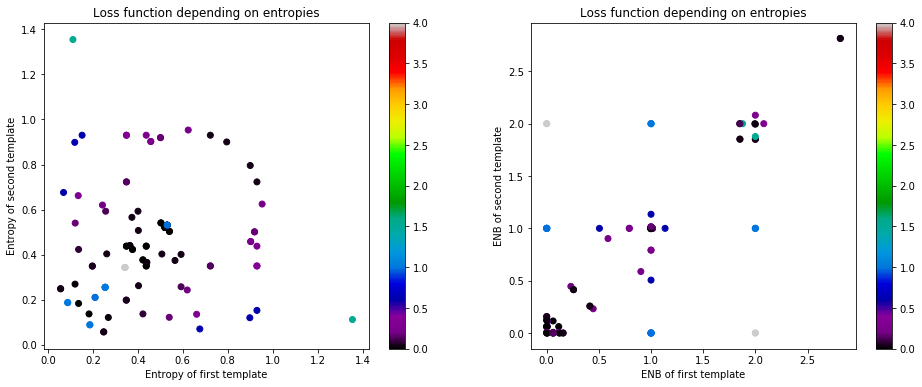

In [68]:
entropies_x = np.empty(0) # data (entropies) to plot on x axis
entropies_y = np.empty(0) # data (entropies) to plot on y axis
ENBs_x = np.empty(0) # data (ENBs) to plot on x axis
ENBs_y = np.empty(0) # data (ENBs) to plot on y axis
color = np.empty(0) # data (loss value) to plot as the color of the dot

# Fill the data on way
used_templates = set()
for template1 in all_templates:
    used_templates.add(template1) # check that we don't do the same computation back and forth
    for template2 in all_templates:
        if(template2 not in used_templates):

            minimum = template_pairs[template1, template2].get('x')
            loss = template_pairs[template1, template2].get('fun')
            color = np.append(color, loss)

            entropy_x = template2entropy_f[template1](minimum[0], minimum[1], minimum[2])
            entropy_y = template2entropy_f[template2](minimum[0], minimum[1], minimum[2])
            entropies_x = np.append(entropies_x, entropy_x)
            entropies_y = np.append(entropies_y, entropy_y)
            
            ENB_x = template2ENB_f[template1](minimum[0], minimum[1], minimum[2])
            ENB_y = template2ENB_f[template2](minimum[0], minimum[1], minimum[2])
            ENBs_x = np.append(ENBs_x, ENB_x)
            ENBs_y = np.append(ENBs_y, ENB_y)
            

# Fill data other way
color = np.append(color, color)

entropies_x_old = entropies_x
entropies_x = np.append(entropies_x, entropies_y)
entropies_y = np.append(entropies_y, entropies_x_old)

ENBs_x_old = ENBs_x
ENBs_x = np.append(ENBs_x, ENBs_y)
ENBs_y = np.append(ENBs_y, ENBs_x_old)

# Plot
from matplotlib.pyplot import figure
figure(num=None, figsize=(16, 6))

plt.subplot(1,2,1)
plt.scatter(entropies_x, entropies_y,  c=color, cmap='nipy_spectral')
plt.title('Loss function depending on entropies')
plt.xlabel('Entropy of first template')
plt.ylabel('Entropy of second template')
plt.colorbar()

plt.subplot(1,2,2)
plt.scatter(ENBs_x, ENBs_y,  c=color, cmap='nipy_spectral')
plt.title('Loss function depending on entropies')
plt.xlabel('ENB of first template')
plt.ylabel('ENB of second template')
plt.colorbar()

plt.show()

# Histogram of the template couples' loss values

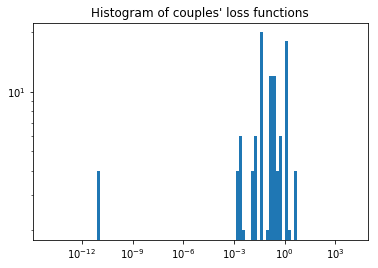

In [63]:
all_losses = list()

for results in template_pairs.values():
    all_losses.append( results.get('fun') )

import pylab as pl
plt.hist(all_losses, bins=np.logspace(np.log10(10e-15),np.log10(10e3), 100), log=True)  # arguments are passed to np.histogram
pl.gca().set_xscale("log")
plt.title("Histogram of couples' loss functions")
plt.show()

# Repartition of minima of all pairs of templates over 1 graph

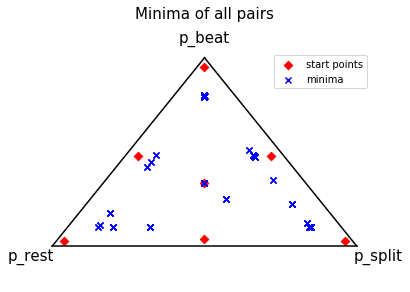

In [244]:
#Graph for the loss function
import ternary
from ternary.helpers import simplex_iterator

def plot_all_templates(template_pairs, scale=40):
    '''
    Function plotting the minimas of all pairs of templates
    '''

    figure, tax = ternary.figure(scale=scale) 
    tax.boundary()
    tax.scatter([tuple([scale*y for y in x]) for x in start_points.values()], color='red', marker="D", label='start points') # plot start points
    tax.scatter([scale*x.get('x') for x in template_pairs.values()], color='blue', marker='x', label='minima') # plot minimas
    
    tax.legend()
    fontsize = 15
    tax.set_title("Minima of all pairs", fontsize=fontsize,y=1.12)
    tax.left_corner_label("p_rest", fontsize=fontsize)
    tax.right_corner_label("p_split", fontsize=fontsize)
    tax.top_corner_label("p_beat", fontsize=fontsize)
    plt.axis('off')
    plt.savefig("graphs/Minima of all pairs", dpi=400, bbox_inches='tight')
    plt.plot()
    plt.show()
    
plot_all_templates(template_pairs, scale=40)

# Visualization of loss function

We can plot the value of the loss function for 2 selected templates, and have a visual idea of which values for p_split p_beat p_rest give the better similarity results.

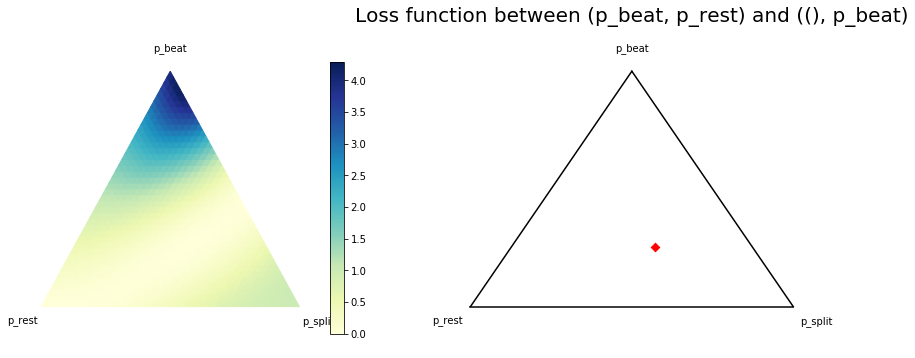

     fun: 1.1425180665383951e-11
     jac: array([-0.00063814,  0.0040742 ,  0.00306033])
 message: 'Optimization terminated successfully.'
    nfev: 69
     nit: 13
    njev: 13
  status: 0
 success: True
       x: array([0.44466751, 0.2515756 , 0.30375689])

In [310]:
template1=(p_beat, p_rest)
template2=((), p_beat)
plot_templates_similarity(template1, template2, template_pairs, scale=40)
template_pairs[(template1, template2)]

In [ ]:
template1=((p_beat, p_rest), ((), p_beat))
template2=(((), p_beat),((), p_beat))

plot_templates_similarity(template1, template2, scale=40)
template_pairs[(template1, template2)]

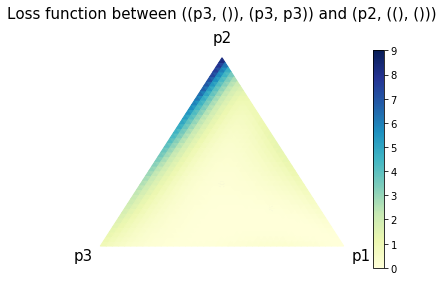

[     fun: 1.348911498947592e-09
     jac: array([8.55262959e-06, 6.94121818e-05, 6.16508577e-05])
 message: 'Optimization terminated successfully.'
    nfev: 37
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.49257671, 0.13460764, 0.37281565])]

In [40]:
template1=((p_rest, ()), (p_rest, p_rest))
template2=(p_beat, ((),()))

plot_templates_similarity(template1, template2, scale=40)
template_pairs[(template1, template2)]

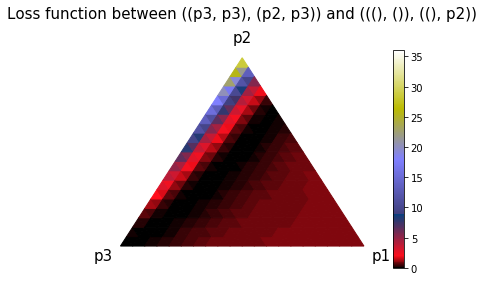

     fun: 1.2900225139333485e-07
     jac: array([ 0.00058219, -0.00380225, -0.00322286])
 message: 'Optimization terminated successfully.'
    nfev: 39
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.22112041, 0.45147505, 0.32740454])

In [85]:
template1=((p_rest, p_rest), (p_beat, p_rest))
template2=(((), ()), ((),p_beat))

plot_templates_similarity(template1, template2, scale=20)
template_pairs[(template1, template2)]

### 1 zero value

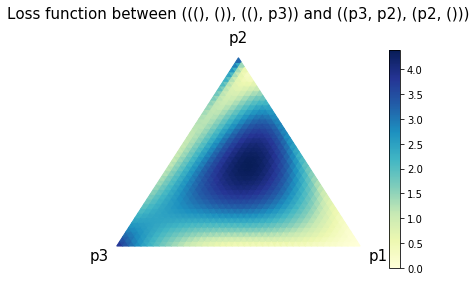

[     fun: 0.770213269677625
     jac: array([0.56083837, 7.68029268, 6.42793034])
 message: 'Optimization terminated successfully.'
    nfev: 10
     nit: 11
    njev: 10
  status: 0
 success: True
       x: array([0.8, 0.1, 0.1])]

In [86]:
template2= ((p_rest, p_beat), (p_beat, ()))
template1= (((), ()), ((), p_rest))

plot_templates_similarity(template1, template2, scale=40)
template_pairs[(template1, template2)]

#template2ENB_f[template2](5.99773336e-01, 2.67323201e-11, 4.00226664e-01)

### 2 zero values

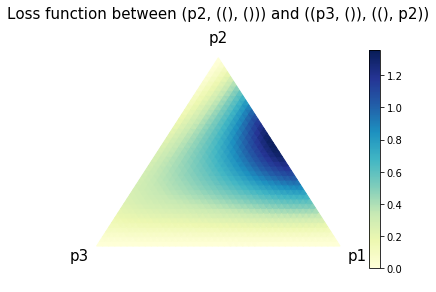

[     fun: 0.12458655512050666
     jac: array([0.11326504, 1.44462391, 0.00506734])
 message: 'Optimization terminated successfully.'
    nfev: 2
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([0.1, 0.1, 0.8])]

In [87]:
template2=  ((p_rest, ()), ((), p_beat))
template1=  (p_beat,((),()))

plot_templates_similarity(template1, template2, scale=40)
template_pairs[(template1, template2)]

In [120]:
template1=((p_beat, p_beat), (p_beat, ()))
template2=(p_beat,((),()))

plot_templates_similarity(template1, template2, scale=40)
template_pairs[(template1, template2)]

KeyError: ((p2, p2), (p2, ()))